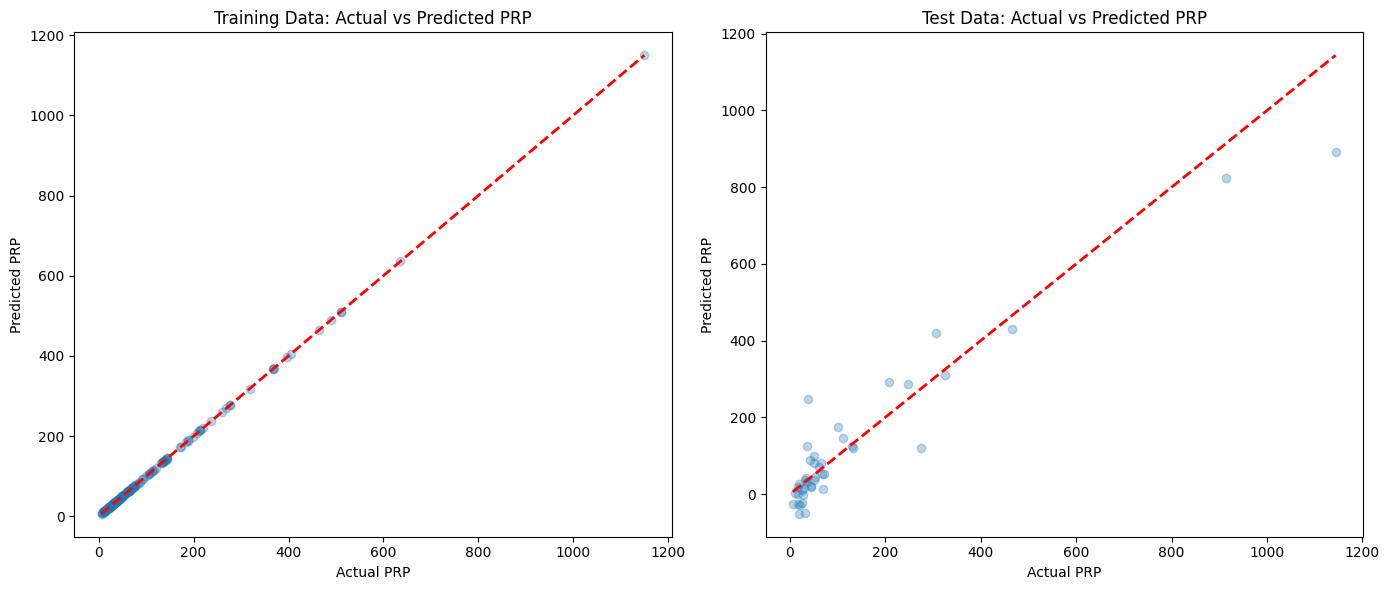

(array([0.77465101, 0.84341946, 0.24220435, 0.86411117, 0.77899997]),
 {'MSE': 3.313340825511833e-06,
  'MAE': 0.0012873840599042607,
  'R2': 0.9999999998276496},
 {'MSE': 4656.553897274854,
  'MAE': 29.185705480379923,
  'R2': 0.908527956318503})

In [3]:
# 1. 데이터 탐색 및 전처

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# 데이터셋 로드
file_path = 'machine.data_update.csv'
data = pd.read_csv(file_path, header=None)

# 컬럼 이름 할당
column_names = ["VendorName", "ModelName", "MYCT", "MMIN", "MMAX", "CACH", "CHMIN", "CHMAX", "PRP", "ERP"]
data.columns = column_names

# 'ERP' 열 제거 (예측에 사용하지 않음)
data = data.drop(columns=['ERP'])

# 수치형 변수 타입 변환
numerical_columns = ["MYCT", "MMIN", "MMAX", "CACH", "CHMIN", "CHMAX", "PRP"]
for col in numerical_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# 결측값 처리
data = data.dropna()

# 특성과 목표 변수 분리
X = data.drop(columns=['PRP'])
y = data['PRP']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 전처리 파이프라인 정의
numerical_features = ["MYCT", "MMIN", "MMAX", "CACH", "CHMIN", "CHMAX"]
categorical_features = ["VendorName", "ModelName"]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 모델 파이프라인 정의
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 파이프라인을 사용하여 모델 학습
pipeline.fit(X_train, y_train)

# 교차 검증
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

# 학습 데이터 평가
y_train_pred = pipeline.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 데이터 평가
y_test_pred = pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_results = {
    'MSE': train_mse,
    'MAE': train_mae,
    'R2': train_r2
}

test_results = {
    'MSE': test_mse,
    'MAE': test_mae,
    'R2': test_r2
}

cv_scores, train_results, test_results

#2. 분석 결과 시각화

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r', linewidth=2)
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Training Data: Actual vs Predicted PRP')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Test Data: Actual vs Predicted PRP')

plt.tight_layout()
plt.show()

#3. 모델 성능 평가 및 개선

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# PolynomialFeatures를 사용한 모델 파이프라인 정의
poly_pipeline = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=2),
    LinearRegression()
)

# 교차 검증을 통해 모델 학습 및 평가
poly_cv_scores = cross_val_score(poly_pipeline, X_train, y_train, cv=5, scoring='r2')

# 파이프라인을 사용하여 모델 학습
poly_pipeline.fit(X_train, y_train)

# 학습 데이터 평가
y_train_pred_poly = poly_pipeline.predict(X_train)
train_mse_poly = mean_squared_error(y_train, y_train_pred_poly)
train_mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
train_r2_poly = r2_score(y_train, y_train_pred_poly)

# 테스트 데이터 평가
y_test_pred_poly = poly_pipeline.predict(X_test)
test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)
test_mae_poly = mean_absolute_error(y_test, y_test_pred_poly)
test_r2_poly = r2_score(y_test, y_test_pred_poly)

train_results_poly = {
    'MSE': train_mse_poly,
    'MAE': train_mae_poly,
    'R2': train_r2_poly
}

test_results_poly = {
    'MSE': test_mse_poly,
    'MAE': test_mae_poly,
    'R2': test_r2_poly
}

poly_cv_scores, train_results_poly, test_results_poly
